In [1]:
# %env CUDA_VISIBLE_DEVICES="0"
import argparse
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import torch
import imageio
import matplotlib.pyplot as plt
import sys
import matplotlib.cm as cm
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from model_selection import model_type, pre_trained_model_types, select_model
from datasets.util import pad_to_same_shape
torch.set_grad_enabled(False)
from utils_flow.pixel_wise_mapping import remap_using_flow_fields
from utils_flow.visualization_utils import overlay_semantic_mask, make_sparse_matching_plot
from utils_flow.util_optical_flow import flow_to_image  
from models.inference_utils import estimate_mask
from utils_flow.flow_and_mapping_operations import convert_flow_to_mapping
from validation.utils import matches_from_flow
from admin.stats import DotDict 
%matplotlib inline

Did not load moviepy


# Define the images to match

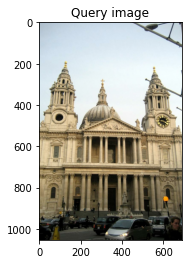

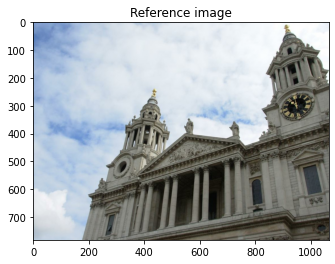

In [2]:
# define the images to match
query_image = imageio.imread('../images/cathedral_2.jpg', pilmode='RGB')
reference_image = imageio.imread('../images/cathedral_1.jpg', pilmode='RGB')
query_image_shape = query_image.shape
ref_image_shape = reference_image.shape
plt.imshow(query_image)
plt.title('Query image')
plt.show()

plt.imshow(reference_image)
plt.title('Reference image')
plt.show()

# Choose the model, and run it to estimate the flow field relating the image pair

In [3]:
print('Possible model types are:')
print(model_type)
print('\nPossible pre-trained model types are:')
print(pre_trained_model_types)

Possible model types are:
['GLUNet', 'GLUNet_interp', 'GLUNet_GOCor', 'PWCNet', 'PWCNet_GOCor', 'GLUNet_GOCor_star', 'PDCNet', 'PDCNet_plus', 'GLUNet_star', 'WarpCGLUNet', 'SemanticGLUNet', 'WarpCSemanticGLUNet', 'WarpCGLUNet_interp', 'SFNet', 'PWarpCSFNet_WS', 'PWarpCSFNet_SS', 'NCNet', 'PWarpCNCNet_WS', 'PWarpCNCNet_SS', 'CATs', 'PWarpCCATs_SS', 'CATs_ft_features', 'PWarpCCATs_ft_features_SS']

Possible pre-trained model types are:
['static', 'dynamic', 'chairs_things', 'chairs_things_ft_sintel', 'megadepth', 'megadepth_stage1', 'pfpascal', 'spair']


In [4]:
# choose model 
model = 'PDCNet_plus'
pre_trained_model = 'megadepth'
flipping_condition = False 
global_optim_iter = 3
local_optim_iter = 7 
path_to_pre_trained_models = '../pre_trained_models/' 
    
if model not in model_type:
    raise ValueError('The model that you chose is not valid: {}'.format(model))
if pre_trained_model not in pre_trained_model_types:
    raise ValueError('The pre-trained model type that you chose is not valid: {}'.format(pre_trained_model))


# inference parameters for PDC-Net
network_type = model  # will only use these arguments if the network_type is 'PDCNet' or 'PDCNet_plus'
choices_for_multi_stage_types = ['d', 'h', 'ms']
multi_stage_type = 'h'
if multi_stage_type not in choices_for_multi_stage_types:
    raise ValueError('The inference mode that you chose is not valid: {}'.format(multi_stage_type))

confidence_map_R =1.0
ransac_thresh = 1.0
mask_type = 'proba_interval_1_above_10'  # for internal homo estimation
homography_visibility_mask = True
scaling_factors = [0.5, 0.6, 0.88, 1, 1.33, 1.66, 2]
compute_cyclic_consistency_error = True  # here to compare multiple uncertainty 

# usually from argparse
args = DotDict({'network_type': network_type, 'multi_stage_type': multi_stage_type, 'confidence_map_R': confidence_map_R, 
                'ransac_thresh': ransac_thresh, 'mask_type': mask_type, 
                'homography_visibility_mask': homography_visibility_mask, 'scaling_factors': scaling_factors, 
                'compute_cyclic_consistency_error': compute_cyclic_consistency_error})


In [5]:
# define network and load network weights
network, estimate_uncertainty = select_model(
    model, pre_trained_model, args, global_optim_iter, local_optim_iter,
    path_to_pre_trained_models=path_to_pre_trained_models)
estimate_uncertainty = True  
# here, we overwrite it, to also estimate uncertainty according to forward-backward for networks that do not predict a confidence measure

Model: PDCNet_plus
Pre-trained-model: megadepth
GOCor: Local iter 7
GOCor: Global iter 3


In [6]:
# convert the images to correct format to be processed by the network: torch Tensors, format B, C, H, W. 
# pad both images to the same size, to be processed by network
query_image_, reference_image_ = pad_to_same_shape(query_image, reference_image)
# convert numpy to torch tensor and put it in right format
query_image_ = torch.from_numpy(query_image_).permute(2, 0, 1).unsqueeze(0)
reference_image_ = torch.from_numpy(reference_image_).permute(2, 0, 1).unsqueeze(0)

In [7]:
if estimate_uncertainty:
    estimated_flow, uncertainty_components = network.estimate_flow_and_confidence_map(query_image_, reference_image_)
else:
    if args.flipping_condition and 'GLUNet' in args.model:
        estimated_flow = network.estimate_flow_with_flipping_condition(query_image_, reference_image_,
                                                                       mode='channel_first')
    else:
        estimated_flow = network.estimate_flow(query_image_, reference_image_, mode='channel_first')
# removes the padding
estimated_flow = estimated_flow[:, :, :ref_image_shape[0], :ref_image_shape[1]]

# convert to numpy and reformat
estimated_flow_numpy = estimated_flow.squeeze().permute(1, 2, 0).cpu().numpy()

# warp the query image according to the estimated flow
warped_query_image = remap_using_flow_fields(query_image, estimated_flow_numpy[:, :, 0],
                                             estimated_flow_numpy[:, :, 1]).astype(np.uint8)

# Visualization of the warped query and estimated flow field 

/tmp/ipykernel_11406/189285036.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


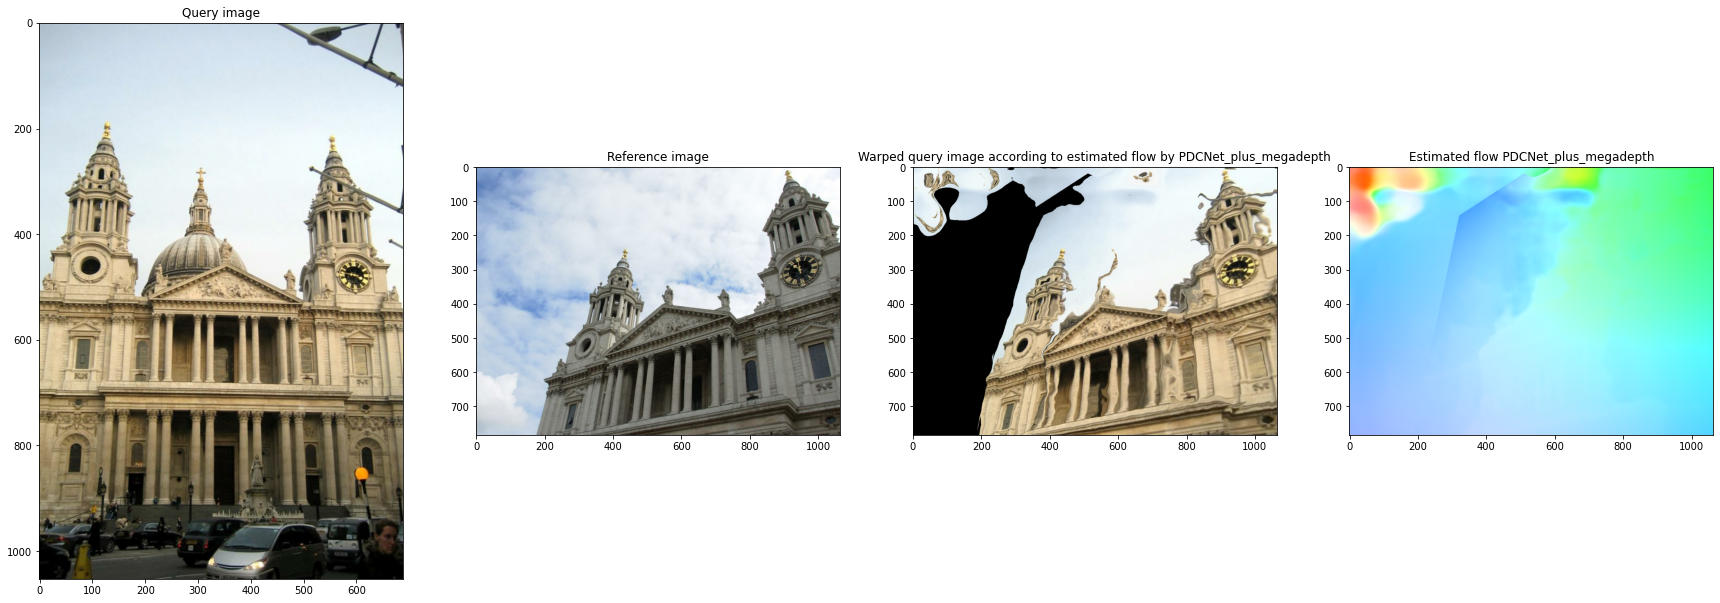

In [8]:
# visualization of warped query image 
fig, axis = plt.subplots(1, 4, figsize=(30, 30))
axis[2].imshow(warped_query_image)
axis[2].set_title(
    'Warped query image according to estimated flow by {}_{}'.format(model, pre_trained_model))
axis[0].imshow(query_image)
axis[0].set_title('Query image')
axis[1].imshow(reference_image)
axis[1].set_title('Reference image')

axis[3].imshow(flow_to_image(estimated_flow_numpy))
axis[3].set_title('Estimated flow {}_{}'.format(model, pre_trained_model))
fig.show()
plt.show()

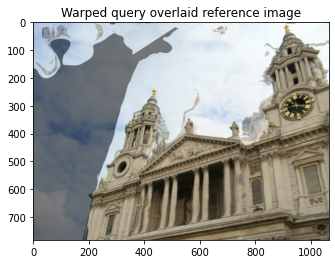

In [9]:
alpha = 0.5
img_warped_overlay_on_target_masked = warped_query_image * alpha + reference_image * alpha
plt.imshow(img_warped_overlay_on_target_masked.astype(np.uint8))
plt.title('Warped query overlaid reference image')
plt.show()

# Let's look at the confidence estimation
Only PDC-Net predicts a confidence value associated with the match (referred to as 'p_r' here). However, other approaches can use the inverse of the forward-backward cyclic consistency as a confidence measure (referred to as 'inv_cyclic_consistency_error' here). You can play around with the different confidence estimation methods and visualize the confident regions as well as top confident matches.  

In [10]:
# confidence estimation + visualization
if not estimate_uncertainty: 
    raise ValueError

print(uncertainty_components.keys())
uncertainty_key = 'p_r'  # 'inv_cyclic_consistency_error' 
#'p_r', 'inv_cyclic_consistency_error' can also be used as a confidence measure
# 'cyclic_consistency_error' can also be used, but that's an uncertainty measure
min_confidence = 0.30
confidence_map = uncertainty_components[uncertainty_key]
confidence_map = confidence_map[:, :, :ref_image_shape[0], :ref_image_shape[1]]

dict_keys(['log_var_map', 'weight_map', 'p_r', 'inference_parameters', 'variance', 'warping_mask', 'cyclic_consistency_error', 'inv_cyclic_consistency_error'])


/tmp/ipykernel_11406/2067321406.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


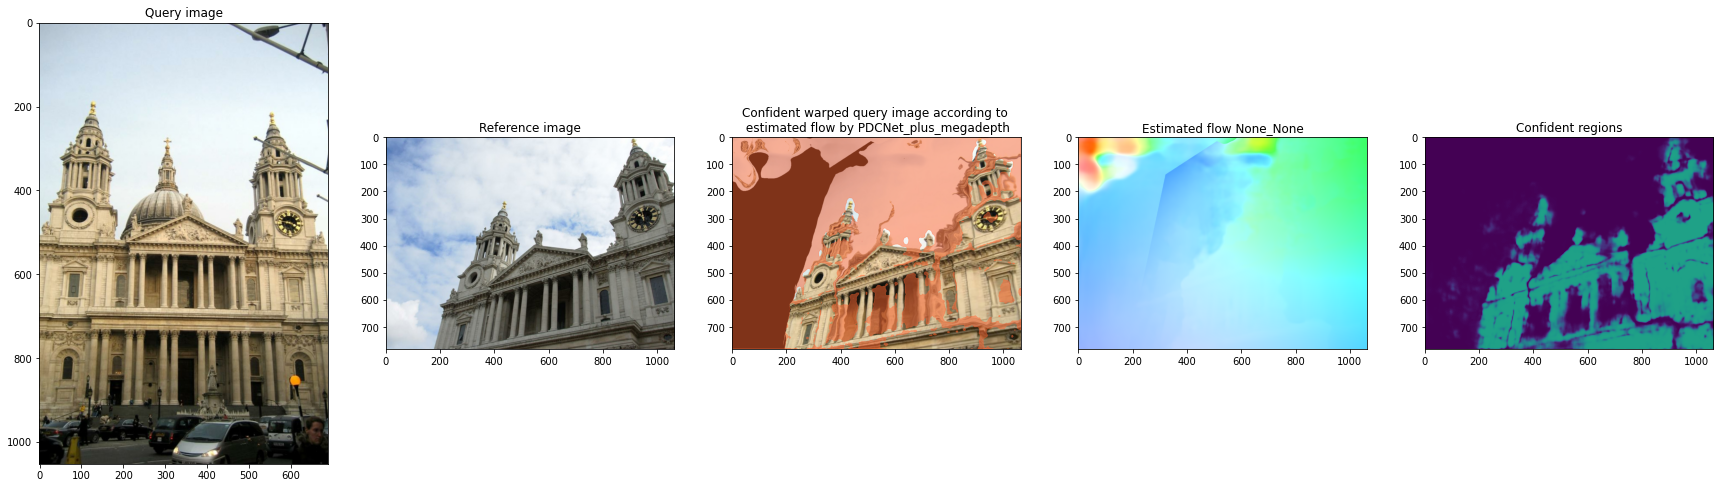

In [11]:
color = [255, 102, 51]
fig, axis = plt.subplots(1, 5, figsize=(30, 30))

confidence_map_numpy = confidence_map.squeeze().detach().cpu().numpy()
confident_mask = (confidence_map_numpy > min_confidence).astype(np.uint8)
confident_warped = overlay_semantic_mask(warped_query_image, ann=255 - confident_mask*255, color=color)
axis[2].imshow(confident_warped)
axis[2].set_title('Confident warped query image according to \n estimated flow by {}_{}'
                  .format(model, pre_trained_model))
axis[4].imshow(confidence_map_numpy, vmin=0.0, vmax=1.0)
axis[4].set_title('Confident regions')

axis[0].imshow(query_image)
axis[0].set_title('Query image')
axis[1].imshow(reference_image)
axis[1].set_title('Reference image')

axis[3].imshow(flow_to_image(estimated_flow_numpy))
axis[3].set_title('Estimated flow {}_{}'.format(args.model, args.pre_trained_model))
fig.show()

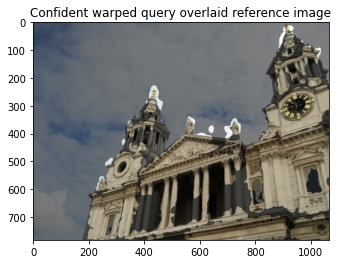

In [12]:
# plot the confident warped regions overlaid on the reference image
alpha=0.5
if estimate_uncertainty:
    img_warped_overlay_on_target_masked = warped_query_image * alpha * np.tile(
        np.expand_dims(confident_mask.astype(np.uint8), axis=2), (1, 1, 3)) + \
         (1 - alpha) * reference_image
else:
    img_warped_overlay_on_target_masked = warped_query_image / 255 * 0.5 + reference_image / 255 * 0.5
plt.imshow(img_warped_overlay_on_target_masked.astype(np.uint8))
plt.title('Confident warped query overlaid reference image')
plt.show()

# Plot the top confident matches
Choose which mask type, either cyclic consistency error below some value or proba_interval_above something. 

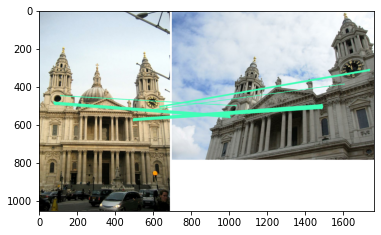

In [13]:
# plot the confident matches, here at original resolution, could have computed at 1/4th resolution
# this can also direclty be computed with 
#network.get_matches_and_confidence(source_image, target_image)


# get the mask according to uncertainty estimation
mask_type = 'proba_interval_1_above_10' # 'cyclic_consistency_error_below_2' 
#'proba_interval_1_above_10' can be used in association with all networks, relying on p_r for PDC-Net 
# and inv_cyclic_consistency_error for the other networks
# Alternatively, can use instead 'cyclic_consistency_error_below_x'
# choices_for_mask_type = ['cyclic_consistency_error_below_x', 'x_percent_most_certain', 'variance_below_x', 
#                          'proba_interval_z_above_x_NMS_y',  'proba_interval_z_above_x_grid_y', 
#                          'proba_interval_z_above_x']  x, y and z are numbers to choose


mask_padded = estimate_mask(mask_type, uncertainty_components) 
if 'warping_mask' in list(uncertainty_components.keys()):
    # get mask from internal multi stage alignment, if it took place
    mask_padded = uncertainty_components['warping_mask'] * mask_padded

# remove the padding
mask = mask_padded[:, :ref_image_shape[0], :ref_image_shape[1]]

# remove point that lead to outside the query image
mapping_estimated = convert_flow_to_mapping(estimated_flow)
mask = mask & mapping_estimated[:, 0].ge(0) & mapping_estimated[:, 1].ge(0) & \
mapping_estimated[:, 0].le(query_image_shape[1] - 1) & mapping_estimated[:, 1].le(query_image_shape[0] - 1)

mkpts_query, mkpts_ref = matches_from_flow(estimated_flow, mask)

confidence_values = confidence_map.squeeze()[mask.squeeze()].cpu().numpy()
sort_index = np.argsort(np.array(confidence_values)).tolist()[::-1]  # from highest to smallest
confidence_values = np.array(confidence_values)[sort_index]
mkpts_query = np.array(mkpts_query)[sort_index]
mkpts_ref = np.array(mkpts_ref)[sort_index]

if len(mkpts_query) < 5:
    mkpts_query = np.empty([0, 2], dtype=np.float32)
    mkpts_ref = np.empty([0, 2], dtype=np.float32)
    confidence_values = np.empty([0], dtype=np.float32)
    
# plot top 300
# k_top = 10000
k_top = 300
mkpts_q = mkpts_query[:k_top]
mkpts_r = mkpts_ref[:k_top]
confidence_values = confidence_values[:k_top]
color = cm.jet(confidence_values)
out = make_sparse_matching_plot(query_image, reference_image, mkpts_q, mkpts_r, color, margin=10)

plt.imshow(out)
plt.show()

In [15]:
print(estimated_flow.shape)
print(mask.shape)

torch.Size([1, 2, 783, 1064])
torch.Size([1, 783, 1064])
